# Architectural Heritage Elements Classification
Bu proje, Akbank Derin Öğrenme Bootcamp 2025 kapsamında geliştirilmiştir.
Amaç, CNN mimarisi kullanarak mimari miras öğelerinin (sunak, apsis, kubbe, uçan payanda vb.) görseller üzerinden sınıflandırılması.

Dataset
Kaynak: Kaggle - Architectural Heritage Elements Image64
Sınıf sayısı: 10
Görsel sayısı: ~10,235

## Yol Haritası
 
0. Gerekli Kütüphaneler
1. Veri Keşif (EDA)  
2. Veri Hazırlık (64x64)  
3. Temel CNN Modeli (64x64)
4. Model Derleme ve Eğitim  
5. Model Değerlendirme
6. VGG16 Transfer Öğrenme (64x64)  
7. VGG16 Transfer Öğrenme (128x128) 
8. VGG16 Fine-Tuning (128x128)
9. Sonuç Karşılaştırma
10. Grad-CAM Açıklanabilirlik
11. Genel Değerlendirme

## 0. Gerekli Kütüphaneler

In [1]:
# ==============================
# Gerekli Kütüphaneler
# ==============================

# Sistem & temel ayarlar
import os, random, time, warnings
warnings.filterwarnings('ignore')

# Veri işleme
import numpy as np
import pandas as pd

# Görselleştirme
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg

# Sklearn metrikler
from sklearn.metrics import confusion_matrix, classification_report

# TensorFlow / Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import plot_model  # (opsiyonel: model görselleştirme)

# Grad-CAM için
import cv2

2025-09-26 15:18:13.713585: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758899894.088366      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758899894.187848      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 1. Veri Keşfi (EDA)
#### a. Modeli eğitmek üzere eğitim ve test verileri hakkında görselleştirmeden de yararlanarak genel bilgiler keşfedildi.
#### b. Sınıflandırmalar türkçeleştirildi.
#### c. Eğitim ve test verileri dağılımı görselleştirme ve tablolaştırmayla incelendi.

Eğitim verisi toplam: 10130
Test verisi toplam: 1404
Sınıf sayısı: 10
Sınıf isimleri: ['altar', 'apse', 'bell_tower', 'column', 'dome(inner)', 'dome(outer)', 'flying_buttress', 'gargoyle', 'stained_glass', 'vault']


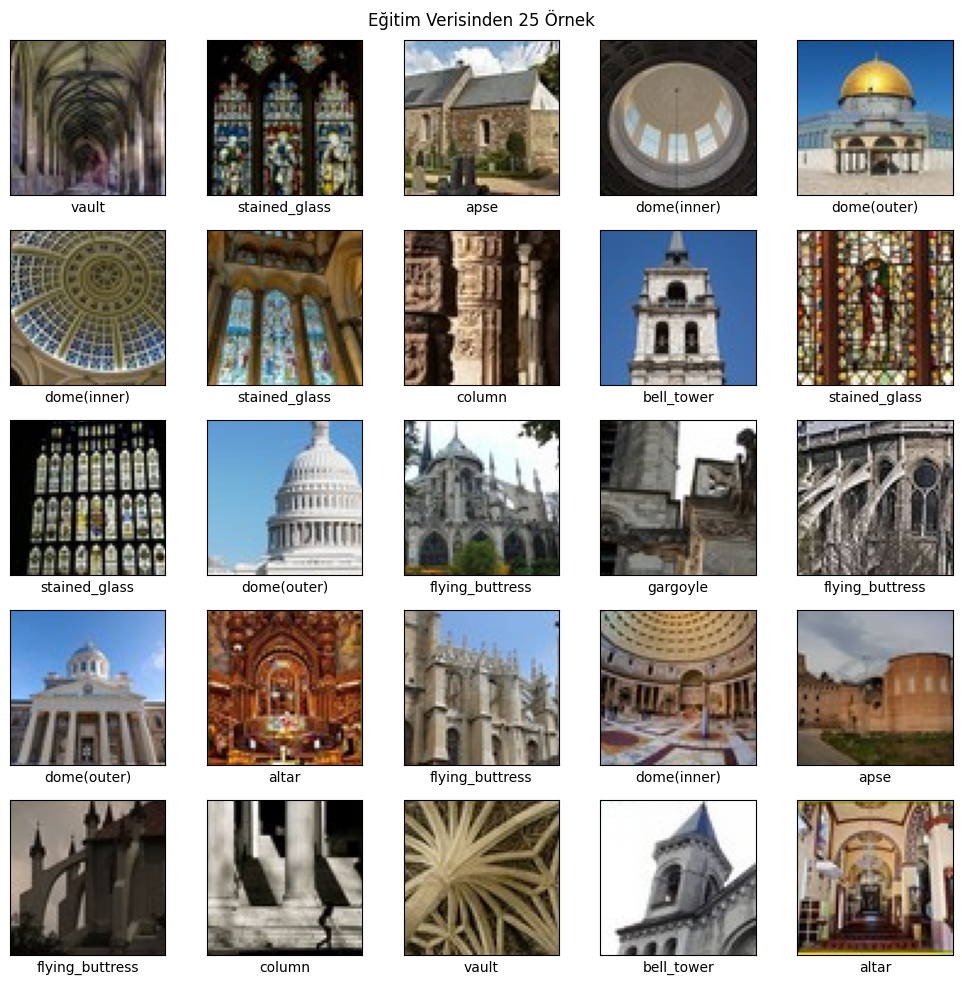

In [2]:


# === 1. Veri Keşfi (EDA) ===

TRAIN_DIR = "/kaggle/input/architectural-heritage-elements-image64-dataset/train"
TEST_DIR  = "/kaggle/input/architectural-heritage-elements-image64-dataset/test"

# === Dataset hakkında genel bilgiler ===
train_count = sum([len(files) for r, d, files in os.walk(TRAIN_DIR)])
test_count  = sum([len(files) for r, d, files in os.walk(TEST_DIR)])

class_names = sorted(os.listdir(TRAIN_DIR))

print("Eğitim verisi toplam:", train_count)
print("Test verisi toplam:", test_count)
print("Sınıf sayısı:", len(class_names))
print("Sınıf isimleri:", class_names)

# === İlk 25 görseli görselleştirelim ===
plt.figure(figsize=(10,10))
for i in range(25):
    cls = random.choice(class_names)
    img_path = os.path.join(TRAIN_DIR, cls, random.choice(os.listdir(os.path.join(TRAIN_DIR, cls))))
    img = mpimg.imread(img_path)
    plt.subplot(5,5,i+1)
    plt.imshow(img)
    plt.xticks([]); plt.yticks([]); plt.grid(False)
    plt.xlabel(cls)   
plt.suptitle("Eğitim Verisinden 25 Örnek")
plt.tight_layout()
plt.show()



Sınıf isimleri (Türkçe): ['Sunak', 'Apsis', 'Çan Kulesi', 'Sütun', 'Kubbe (İç)', 'Kubbe (Dış)', 'Uçan Payanda', 'Yalungöz', 'Vitray', 'Tonoz']


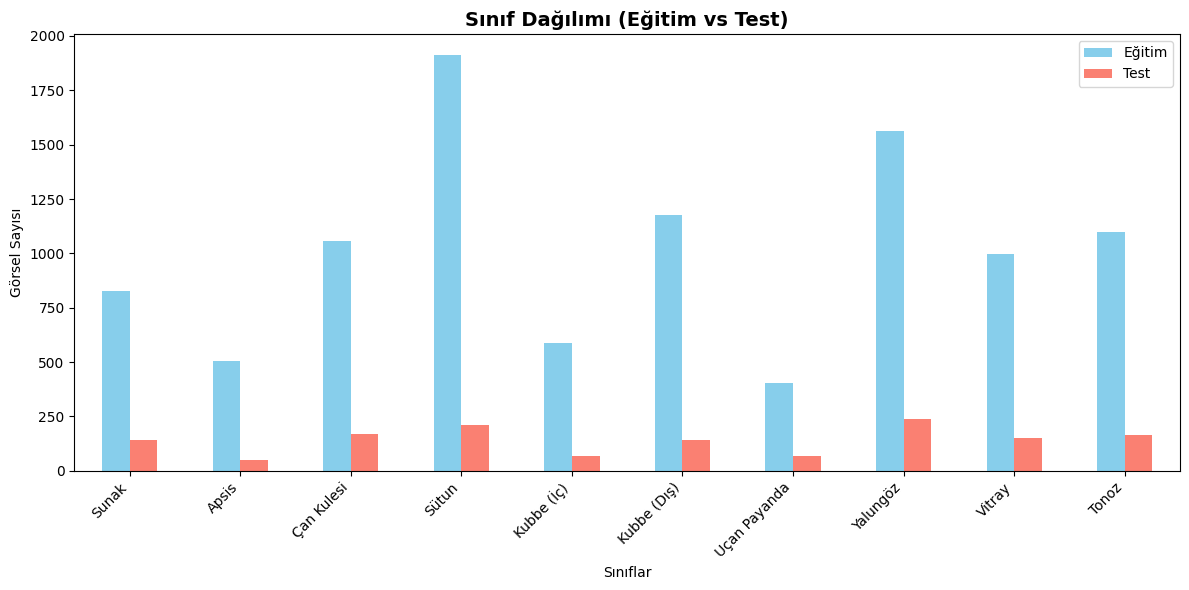

=== Sınıf Dağılımı (Eğitim/Test) ===
              Eğitim  Test
Sunak            828   140
Apsis            505    50
Çan Kulesi      1057   170
Sütun           1914   210
Kubbe (İç)       589    69
Kubbe (Dış)     1175   142
Uçan Payanda     405    70
Yalungöz        1562   240
Vitray           998   150
Tonoz           1097   163


In [3]:
# === Etiket Çevirileri (İng -> Tr) ===
label_map = {
    "altar": "Sunak",
    "apse": "Apsis",
    "bell_tower": "Çan Kulesi",
    "buttress": "Payanda",
    "column": "Sütun",
    "dome(inner)": "Kubbe (İç)",
    "dome(outer)": "Kubbe (Dış)",
    "flying_buttress": "Uçan Payanda",
    "gargoyle": "Yalungöz",
    "vault": "Tonoz",
    "stained_glass": "Vitray"
}
class_names_tr = [label_map.get(c, c) for c in class_names]

print("Sınıf isimleri (Türkçe):", class_names_tr)

# === Eğitim ve Test sınıf dağılımları ===
train_class_counts = {c: len(os.listdir(os.path.join(TRAIN_DIR,c))) for c in class_names}
test_class_counts  = {c: len(os.listdir(os.path.join(TEST_DIR,c))) for c in class_names}

train_counts = pd.DataFrame.from_dict(train_class_counts, orient='index', columns=['Eğitim']).sort_index()
test_counts  = pd.DataFrame.from_dict(test_class_counts, orient='index', columns=['Test']).sort_index()

df_counts = pd.concat([train_counts, test_counts], axis=1)
df_counts.index = [label_map.get(c, c) for c in df_counts.index]  # Türkçeleştir

# Barplot
df_counts.plot(kind="bar", figsize=(12,6), color=["skyblue","salmon"])
plt.title("Sınıf Dağılımı (Eğitim vs Test)", fontsize=14, fontweight="bold")
plt.ylabel("Görsel Sayısı")
plt.xlabel("Sınıflar")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("=== Sınıf Dağılımı (Eğitim/Test) ===")
print(df_counts)

## 2. Veri Hazırlık (64x64 ,128x128)
#### a. Veri artırma ve test seti normalize etme yöntemleriyle veri eğitime hazırlandı.

In [4]:
IMG_SIZE_SMALL = (64,64)
IMG_SIZE_BIG = (128,128)
BATCH_SIZE = 32
SEED = 42

# Veri artırma ile eğitim generatörü
train_datagen = ImageDataGenerator(
    rescale=1./255,                    # 0-1 arası normalizasyon
    validation_split=0.2,              # %20 validation
    rotation_range=20,                 # ±20° döndürme
    width_shift_range=0.1,             # %10 yatay kaydırma
    height_shift_range=0.1,            # %10 dikey kaydırma
    zoom_range=0.1,                    # %10 yakınlaştırma
    horizontal_flip=True,              # yatay çevirme
    fill_mode="nearest"                # boş pikselleri doldurma
)

# Test seti normalize edilir
test_datagen = ImageDataGenerator(rescale=1./255)

# 64x64 boyutunda generatörler
train_gen_64 = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=IMG_SIZE_SMALL, batch_size=BATCH_SIZE,
    class_mode="categorical", subset="training", seed=SEED
)
val_gen_64 = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=IMG_SIZE_SMALL, batch_size=BATCH_SIZE,
    class_mode="categorical", subset="validation", seed=SEED
)
test_gen_64 = test_datagen.flow_from_directory(
    TEST_DIR, target_size=IMG_SIZE_SMALL, batch_size=BATCH_SIZE,
    class_mode="categorical", shuffle=False
)

# Sınıf etiketleri
class_labels_en = list(train_gen_64.class_indices.keys())
class_labels_tr = [label_map.get(c, c) for c in class_labels_en]

print(f"Sınıf sayısı: {len(class_labels_en)}")
print(f"Türkçe etiketler: {class_labels_tr}")

Found 8108 images belonging to 10 classes.
Found 2022 images belonging to 10 classes.
Found 1404 images belonging to 10 classes.
Sınıf sayısı: 10
Türkçe etiketler: ['Sunak', 'Apsis', 'Çan Kulesi', 'Sütun', 'Kubbe (İç)', 'Kubbe (Dış)', 'Uçan Payanda', 'Yalungöz', 'Vitray', 'Tonoz']


## 3. Temel CNN Modeli(64x64)

In [22]:


# =========================
# 3. TEMEL CNN MODELİ
# =========================


def create_baseline_cnn():
    """
    Mimari miras öğeleri sınıflandırması için temel CNN modeli
    """
    model = keras.Sequential([
        # İlk evrişim bloğu
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 3)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),

        # İkinci evrişim bloğu
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        # Üçüncü evrişim bloğu
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        # Sınıflandırıcı katmanlar
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(len(class_names), activation='softmax')  # 11 sınıf için
    ])
    return model

# Modeli oluşturalım
baseline_cnn = create_baseline_cnn()

# Model özetini görüntüleyelim
print("Temel CNN Model Özeti:")
baseline_cnn.summary()


Temel CNN Model Özeti:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,338,410 (5.11 MB)

 Trainable params: 1,337,706 (5.10 MB)

 Non-trainable params: 704 (2.75 KB)

## 4. Model Derleme ve Eğitim

Model eğitimi başlıyor...
Epoch 1/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 44s 132ms/step - accuracy: 0.3267 - loss: 2.0863 - val_accuracy: 0.2730 - val_loss: 2.4114 - learning_rate: 0.0010
Epoch 2/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 28s 110ms/step - accuracy: 0.5606 - loss: 1.2858 - val_accuracy: 0.3813 - val_loss: 1.8219 - learning_rate: 0.0010
Epoch 3/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 29s 113ms/step - accuracy: 0.6125 - loss: 1.1124 - val_accuracy: 0.5885 - val_loss: 1.2486 - learning_rate: 0.0010
Epoch 4/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 28s 110ms/step - accuracy: 0.6447 - loss: 1.0228 - val_accuracy: 0.6004 - val_loss: 1.2234 - learning_rate: 0.0010
Epoch 5/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 28s 112ms/step - accuracy: 0.6737 - loss: 0.9354 - val_accuracy: 0.6147 - val_loss: 1.2162 - learning_rate: 0.0010
Epoch 6/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 28s 109ms/step - accuracy: 0.7180 - loss: 0.8317 - val_accuracy: 0.7171 - val_loss: 0.8286 - learning_rate: 0.0010
Epoch 7/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 28s 

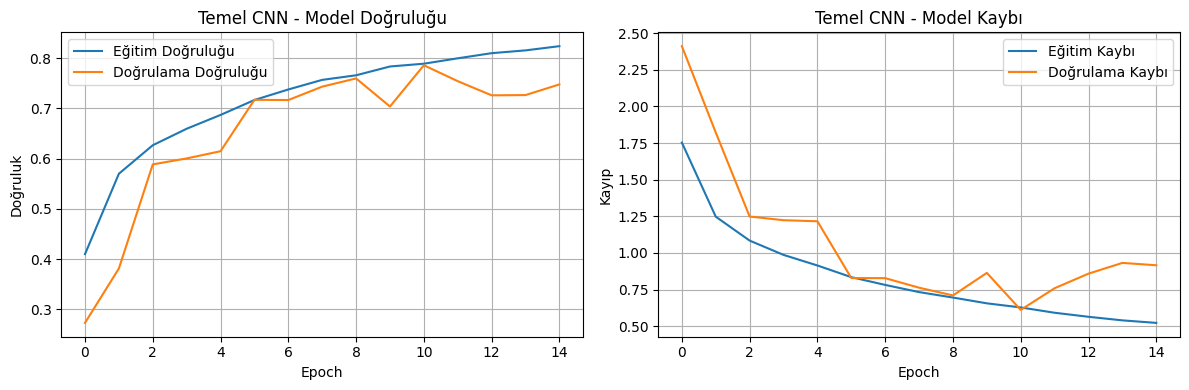

En iyi doğrulama doğruluğu: 0.7859 (78.59%)


In [32]:
# =========================
# 4. MODEL DERLEMESİ VE EĞİTİM
# =========================

# Modeli derleyelim
baseline_cnn.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Callback'leri tanımlayalım (erken durdurma ve öğrenme oranı ayarlama)
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.0001
)

# Modeli eğitelim
print("Model eğitimi başlıyor...")
start_time = time.time()

history_baseline = baseline_cnn.fit(
    train_gen_64,
    epochs=15,
    validation_data=val_gen_64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

training_time = time.time() - start_time
print(f"Eğitim süresi: {training_time:.2f} saniye")

# Eğitim ve doğrulama kaybı/doğruluğunu görselleştirelim
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_baseline.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history_baseline.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Temel CNN - Model Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_baseline.history['loss'], label='Eğitim Kaybı')
plt.plot(history_baseline.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Temel CNN - Model Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# En iyi doğrulama doğruluğunu kaydedelim
baseline_acc = max(history_baseline.history['val_accuracy'])
print(f"En iyi doğrulama doğruluğu: {baseline_acc:.4f} ({baseline_acc*100:.2f}%)")

## 5. Model Değerlendirme
#### a. Test doğruluğu ölçümü, sınıflandırma raporu ve karışıklık matrisi oluşturulması yöntemleriyle modelin performansı detaylı incelendi.

Test Kaybı: 0.9617
Test Doğruluğu: 0.7030 (70.30%)
Test seti tahminleri yapılıyor...

Sınıflandırma Raporu:
              precision    recall  f1-score   support

       Sunak       0.59      0.86      0.70       140
       Apsis       0.25      0.88      0.39        50
  Çan Kulesi       0.71      0.66      0.69       170
       Sütun       0.95      0.53      0.68       210
  Kubbe (İç)       0.82      0.93      0.87        69
 Kubbe (Dış)       0.74      0.85      0.79       142
Uçan Payanda       0.48      0.57      0.52        70
    Yalungöz       0.97      0.58      0.73       240
      Vitray       0.76      0.99      0.86       150
       Tonoz       0.97      0.54      0.69       163

    accuracy                           0.70      1404
   macro avg       0.72      0.74      0.69      1404
weighted avg       0.79      0.70      0.71      1404



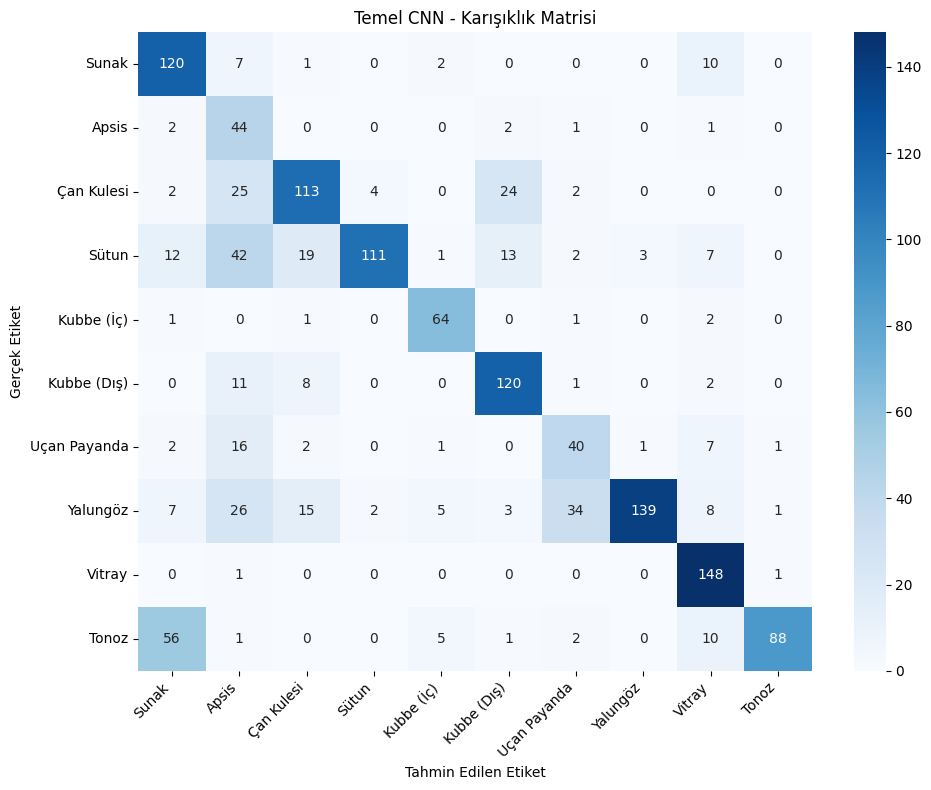

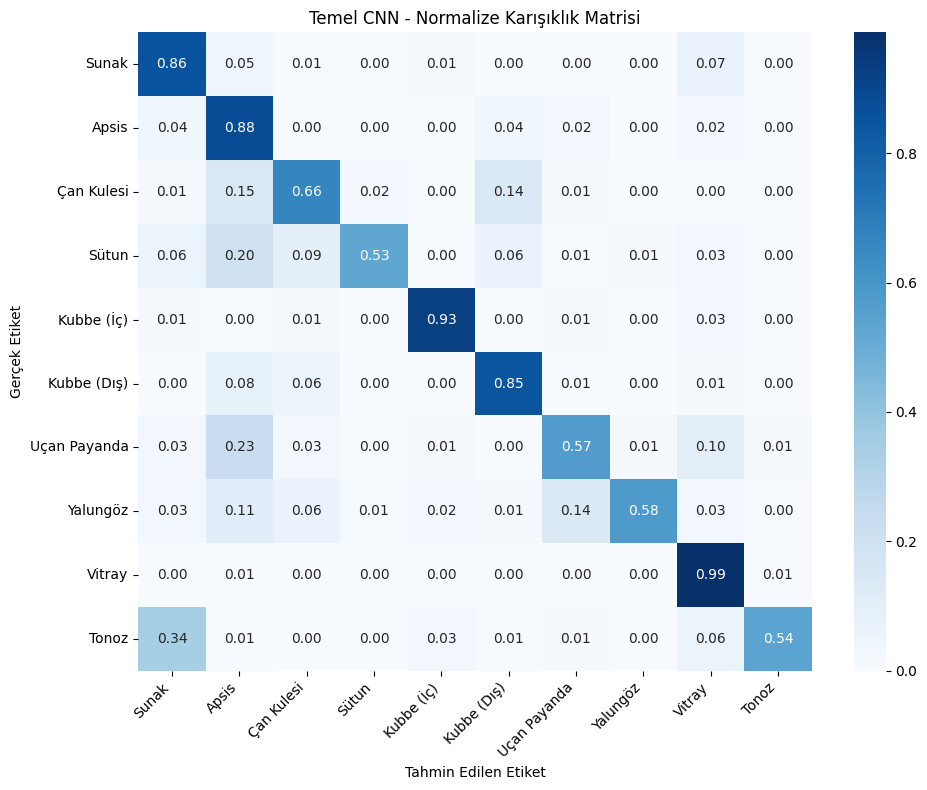

Doğru tahmin örnekleri:
Yanlış tahmin örnekleri:


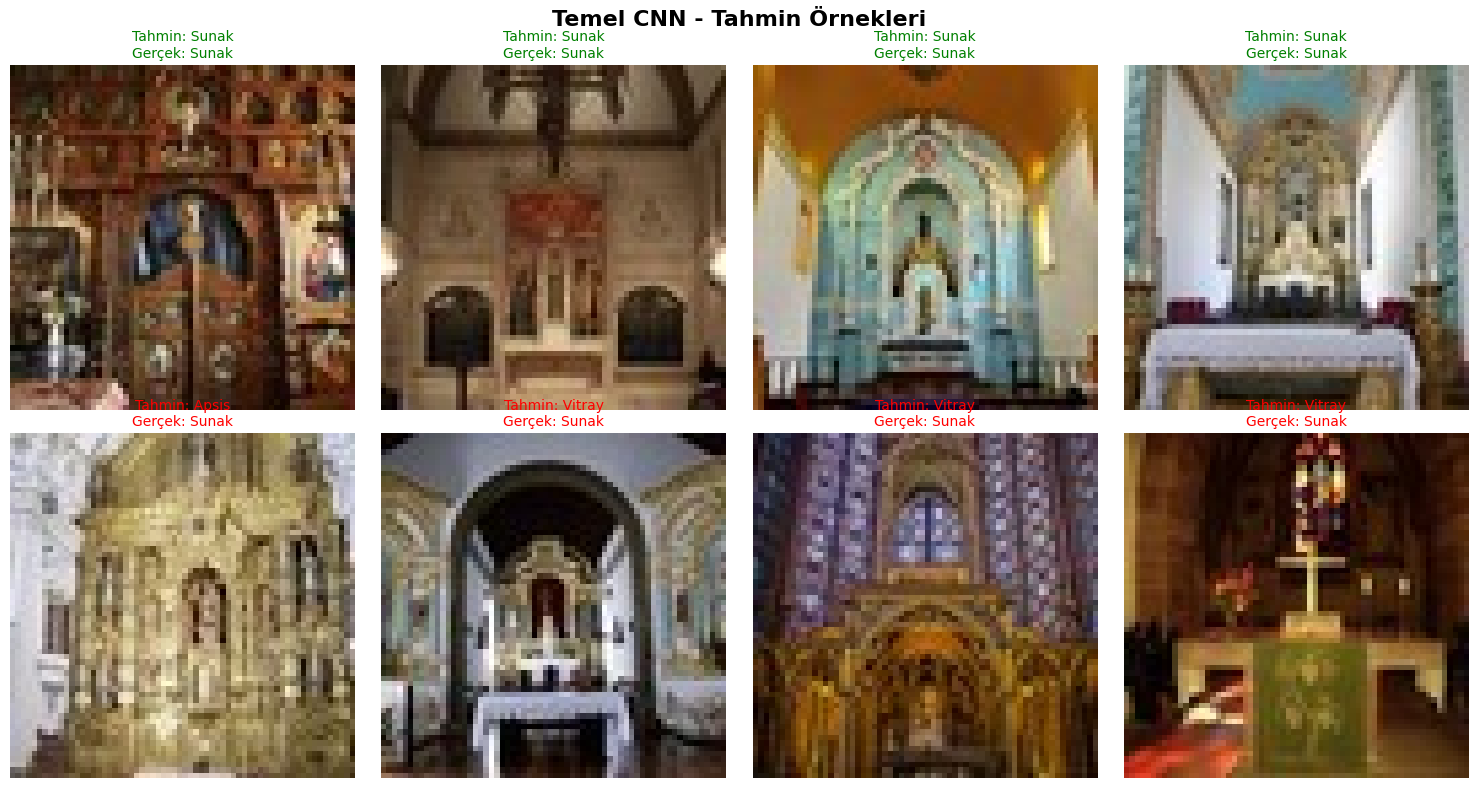

In [34]:
# =========================
# 5. MODEL DEĞERLENDİRME
# =========================

# Test seti üzerinde modeli değerlendirelim
test_loss, test_accuracy = baseline_cnn.evaluate(test_gen_64, verbose=0)
print(f"Test Kaybı: {test_loss:.4f}")
print(f"Test Doğruluğu: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Tahminlerde bulunalım
print("Test seti tahminleri yapılıyor...")
y_pred = baseline_cnn.predict(test_gen_64, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen_64.classes

# Sınıflandırma raporu 
print("\nSınıflandırma Raporu:")
print(classification_report(y_true, y_pred_classes, target_names=class_names_tr))

# Karışıklık matrisi
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names_tr, yticklabels=class_names_tr)
plt.title('Temel CNN - Karışıklık Matrisi')
plt.ylabel('Gerçek Etiket')
plt.xlabel('Tahmin Edilen Etiket')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Normalize edilmiş karışıklık matrisi
cm_normalized = confusion_matrix(y_true, y_pred_classes, normalize='true')
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names_tr, yticklabels=class_names_tr)
plt.title('Temel CNN - Normalize Karışıklık Matrisi')
plt.ylabel('Gerçek Etiket')
plt.xlabel('Tahmin Edilen Etiket')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Bazı doğru ve yanlış tahmin örneklerini görselleştirelim
correct_indices = np.where(y_pred_classes == y_true)[0]
incorrect_indices = np.where(y_pred_classes != y_true)[0]

plt.figure(figsize=(15, 8))

# Doğru tahmin örnekleri
print("Doğru tahmin örnekleri:")
for i, correct in enumerate(correct_indices[:4]):
    plt.subplot(2, 4, i+1)
    # Test generatöründen görüntüyü al
    img_path = test_gen_64.filepaths[correct]
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.title(f"Tahmin: {class_names_tr[y_pred_classes[correct]]}\nGerçek: {class_names_tr[y_true[correct]]}", 
              color='green', fontsize=10)
    plt.axis('off')

# Yanlış tahmin örnekleri
print("Yanlış tahmin örnekleri:")
for i, incorrect in enumerate(incorrect_indices[:4]):
    plt.subplot(2, 4, i+5)
    img_path = test_gen_64.filepaths[incorrect]
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.title(f"Tahmin: {class_names_tr[y_pred_classes[incorrect]]}\nGerçek: {class_names_tr[y_true[incorrect]]}", 
              color='red', fontsize=10)
    plt.axis('off')

plt.suptitle('Temel CNN - Tahmin Örnekleri', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 6. VGG16 Transfer Öğrenme (64×64)

#### a. VGG16 tabanlı transfer öğrenme modeli derlendi.

VGG16 (64x64) Model Özeti:


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 15,242,826 (58.15 MB)

 Trainable params: 15,242,314 (58.14 MB)

 Non-trainable params: 512 (2.00 KB)

VGG16 (64x64) eğitimi başlıyor...
Epoch 1/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 41s 126ms/step - accuracy: 0.2302 - loss: 2.2306 - val_accuracy: 0.1044 - val_loss: 38.2954 - learning_rate: 5.0000e-04
Epoch 2/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 28s 109ms/step - accuracy: 0.3558 - loss: 1.7582 - val_accuracy: 0.1053 - val_loss: 5.2877 - learning_rate: 5.0000e-04
Epoch 3/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 29s 115ms/step - accuracy: 0.4147 - loss: 1.5793 - val_accuracy: 0.1207 - val_loss: 5.7016 - learning_rate: 5.0000e-04
Epoch 4/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 30s 118ms/step - accuracy: 0.4889 - loss: 1.4136 - val_accuracy: 0.3501 - val_loss: 2.2454 - learning_rate: 5.0000e-04
Epoch 5/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 29s 112ms/step - accuracy: 0.5617 - loss: 1.2330 - val_accuracy: 0.5223 - val_loss: 1.3558 - learning_rate: 5.0000e-04
Epoch 6/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 28s 108ms/step - accuracy: 0.6478 - loss: 1.0179 - val_accuracy: 0.6553 - val_loss: 0.9916 - learning_rate: 5.0000e-04
Epoch 7/15


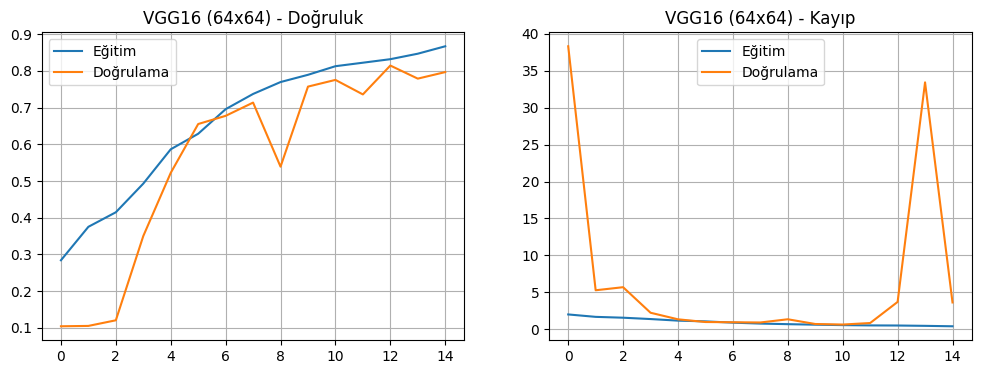

VGG16 (64x64) En iyi doğrulama doğruluğu: 0.8145 (81.45%)


In [18]:
# =========================
# 6. VGG16 TRANSFER ÖĞRENME (64x64)
# =========================

def create_vgg16_model(input_size, num_classes, trainable_layers=0):
    """
    VGG16 tabanlı transfer öğrenme modeli
    """
    base_model = VGG16(weights="imagenet", include_top=False, 
                       input_tensor=Input(shape=(*input_size, 3)))
    
    # Katmanları dondur
    for layer in base_model.layers[:-trainable_layers]:
        layer.trainable = False
    
    # Sınıflandırıcı ekle
    x = Flatten()(base_model.output)
    x = Dense(256, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation="softmax")(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

# VGG16 modeli oluştur (64x64, frozen)
vgg16_64 = create_vgg16_model(IMG_SIZE_SMALL, len(class_names), trainable_layers=0)

print("VGG16 (64x64) Model Özeti:")
vgg16_64.summary()

# Modeli derle ve eğit
vgg16_64.compile(optimizer=Adam(learning_rate=5e-4), 
                 loss="categorical_crossentropy", 
                 metrics=["accuracy"])

print("VGG16 (64x64) eğitimi başlıyor...")
start_time = time.time()

history_vgg16_64 = vgg16_64.fit(
    train_gen_64,
    epochs=15,
    validation_data=val_gen_64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

training_time = time.time() - start_time
print(f"VGG16 (64x64) Eğitim süresi: {training_time:.2f} saniye")

# Eğitim grafiklerini çiz
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_vgg16_64.history['accuracy'], label='Eğitim')
plt.plot(history_vgg16_64.history['val_accuracy'], label='Doğrulama')
plt.title('VGG16 (64x64) - Doğruluk')
plt.legend(); plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history_vgg16_64.history['loss'], label='Eğitim')
plt.plot(history_vgg16_64.history['val_loss'], label='Doğrulama')
plt.title('VGG16 (64x64) - Kayıp')
plt.legend(); plt.grid()
plt.show()

vgg16_64_acc = max(history_vgg16_64.history['val_accuracy'])
print(f"VGG16 (64x64) En iyi doğrulama doğruluğu: {vgg16_64_acc:.4f} ({vgg16_64_acc*100:.2f}%)")

## 7. VGG16 Transfer Öğrenme (128x128)

#### a. 128x128 boyutunda generatörler oluşturup aynı modeli daha büyük görsellerle tekrar eğitildi.

Found 8108 images belonging to 10 classes.
Found 2022 images belonging to 10 classes.
Found 1404 images belonging to 10 classes.
VGG16 (128x128) Model Özeti:
Toplam parametreler: 16,815,690
VGG16 (128x128) eğitimi başlıyor...
Epoch 1/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 108s 314ms/step - accuracy: 0.2463 - loss: 2.2378 - val_accuracy: 0.0895 - val_loss: 6.7624 - learning_rate: 5.0000e-04
Epoch 2/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 58s 229ms/step - accuracy: 0.3732 - loss: 1.7450 - val_accuracy: 0.3947 - val_loss: 1.9725 - learning_rate: 5.0000e-04
Epoch 3/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 59s 232ms/step - accuracy: 0.4657 - loss: 1.4762 - val_accuracy: 0.3506 - val_loss: 3.6202 - learning_rate: 5.0000e-04
Epoch 4/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 58s 228ms/step - accuracy: 0.5214 - loss: 1.3610 - val_accuracy: 0.3383 - val_loss: 2.0967 - learning_rate: 5.0000e-04
Epoch 5/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 58s 228ms/step - accuracy: 0.5651 - loss: 1.2217 - val_accuracy: 0.6078 - val_loss: 2.9817 - lear

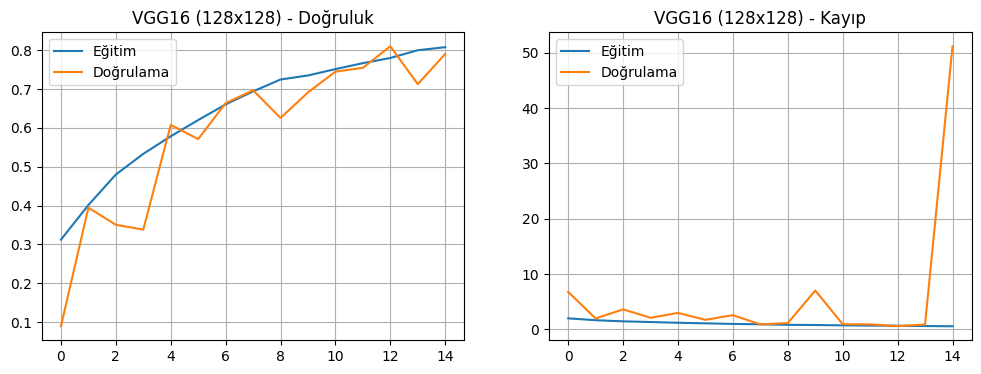

VGG16 (128x128) En iyi doğrulama doğruluğu: 0.8101 (81.01%)


In [16]:
# =========================
# 7. VGG16 TRANSFER ÖĞRENME (128x128)
# =========================

# 128x128 boyutunda generatörler oluştur
train_gen_128 = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=IMG_SIZE_BIG, batch_size=BATCH_SIZE,
    class_mode="categorical", subset="training", seed=SEED
)
val_gen_128 = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=IMG_SIZE_BIG, batch_size=BATCH_SIZE,
    class_mode="categorical", subset="validation", seed=SEED
)
test_gen_128 = test_datagen.flow_from_directory(
    TEST_DIR, target_size=IMG_SIZE_BIG, batch_size=BATCH_SIZE,
    class_mode="categorical", shuffle=False
)

# VGG16 modeli oluştur (128x128, frozen)
vgg16_128 = create_vgg16_model(IMG_SIZE_BIG, len(class_names), trainable_layers=0)

print("VGG16 (128x128) Model Özeti:")
print(f"Toplam parametreler: {vgg16_128.count_params():,}")

# Modeli derle ve eğit
vgg16_128.compile(optimizer=Adam(learning_rate=5e-4), 
                  loss="categorical_crossentropy", 
                  metrics=["accuracy"])

print("VGG16 (128x128) eğitimi başlıyor...")
start_time = time.time()

history_vgg16_128 = vgg16_128.fit(
    train_gen_128,
    epochs=15,
    validation_data=val_gen_128,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

training_time = time.time() - start_time
print(f"VGG16 (128x128) Eğitim süresi: {training_time:.2f} saniye")

# Eğitim grafiklerini çiz
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_vgg16_128.history['accuracy'], label='Eğitim')
plt.plot(history_vgg16_128.history['val_accuracy'], label='Doğrulama')
plt.title('VGG16 (128x128) - Doğruluk')
plt.legend(); plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history_vgg16_128.history['loss'], label='Eğitim')
plt.plot(history_vgg16_128.history['val_loss'], label='Doğrulama')
plt.title('VGG16 (128x128) - Kayıp')
plt.legend(); plt.grid()
plt.show()

vgg16_128_acc = max(history_vgg16_128.history['val_accuracy'])
print(f"VGG16 (128x128) En iyi doğrulama doğruluğu: {vgg16_128_acc:.4f} ({vgg16_128_acc*100:.2f}%)")

## 8. VGG16 Fine-Tuning (128×128)

#### a. Düşük öğrenme oranıyla modeli tekrar derlendi.
#### b. Modelin performansındaki iyileşmenin detaylı analizi için sınıflandırma raporu ve karışıklık matrisi tekrar oluşturuldu.

VGG16 Fine-tune (128x128) Model Özeti:
Eğitilebilir katman sayısı: 9
VGG16 Fine-tuning eğitimi başlıyor...
Epoch 1/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 64s 233ms/step - accuracy: 0.3525 - loss: 2.1406 - val_accuracy: 0.7710 - val_loss: 0.7693 - learning_rate: 1.0000e-05
Epoch 2/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 57s 223ms/step - accuracy: 0.7226 - loss: 0.8465 - val_accuracy: 0.8452 - val_loss: 0.4976 - learning_rate: 1.0000e-05
Epoch 3/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 59s 232ms/step - accuracy: 0.8056 - loss: 0.6033 - val_accuracy: 0.8754 - val_loss: 0.4151 - learning_rate: 1.0000e-05
Epoch 4/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 58s 230ms/step - accuracy: 0.8433 - loss: 0.5040 - val_accuracy: 0.8783 - val_loss: 0.3848 - learning_rate: 1.0000e-05
Epoch 5/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 55s 216ms/step - accuracy: 0.8599 - loss: 0.4378 - val_accuracy: 0.8991 - val_loss: 0.3202 - learning_rate: 1.0000e-05
Epoch 6/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 53s 207ms/step - accuracy: 0.8747 - loss: 0.3815 - val_acc

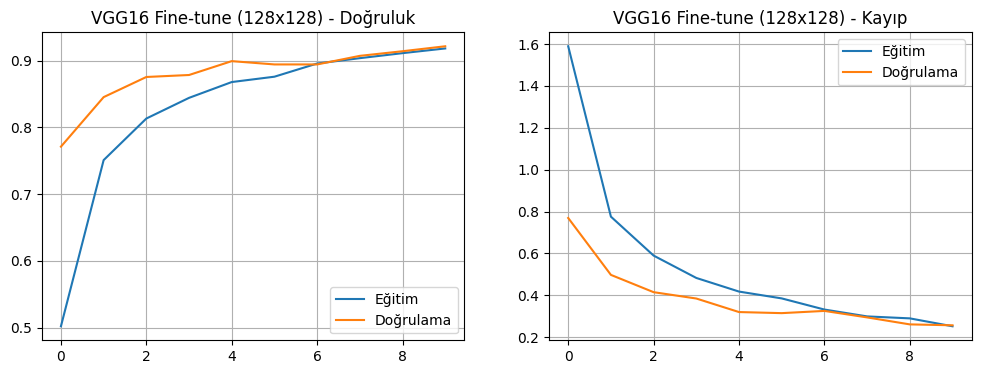

Fine-tune Test Kaybı: 0.2737
Fine-tune Test Doğruluğu: 0.9167 (91.67%)

VGG16 Fine-tune Sınıflandırma Raporu:
              precision    recall  f1-score   support

       Sunak       0.90      0.93      0.92       140
       Apsis       0.69      0.80      0.74        50
  Çan Kulesi       0.87      0.92      0.89       170
       Sütun       0.93      0.91      0.92       210
  Kubbe (İç)       0.94      0.97      0.96        69
 Kubbe (Dış)       0.94      0.93      0.93       142
Uçan Payanda       0.81      0.86      0.83        70
    Yalungöz       0.96      0.89      0.92       240
      Vitray       0.99      0.97      0.98       150
       Tonoz       0.94      0.94      0.94       163

    accuracy                           0.92      1404
   macro avg       0.90      0.91      0.90      1404
weighted avg       0.92      0.92      0.92      1404



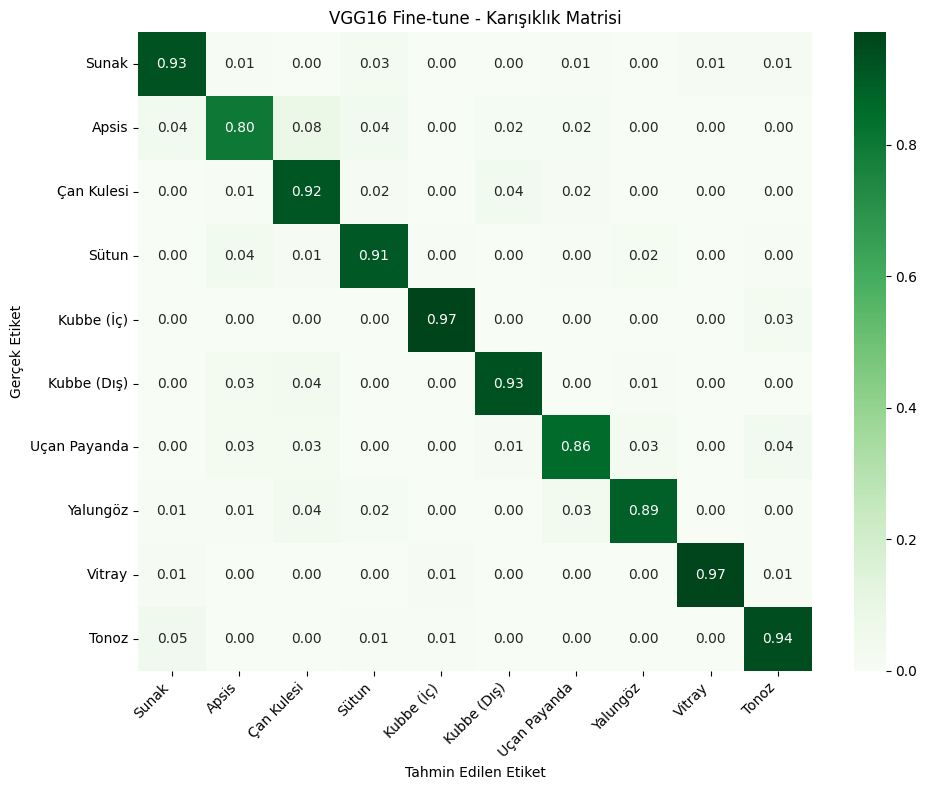

VGG16 Fine-tune En iyi doğrulama doğruluğu: 0.9214 (92.14%)


In [19]:
# =========================
# 8. VGG16 FINE-TUNING (128x128)
# =========================

# VGG16 modeli oluştur (128x128, son 4 katman eğitilebilir)
vgg16_finetune = create_vgg16_model(IMG_SIZE_BIG, len(class_names), trainable_layers=4)

print("VGG16 Fine-tune (128x128) Model Özeti:")
trainable_count = sum([layer.trainable for layer in vgg16_finetune.layers])
print(f"Eğitilebilir katman sayısı: {trainable_count}")

# Düşük öğrenme oranıyla derle (fine-tuning için önemli)
vgg16_finetune.compile(optimizer=Adam(learning_rate=1e-5), 
                       loss="categorical_crossentropy", 
                       metrics=["accuracy"])

# Fine-tuning için callback'leri ayarla
early_stopping_ft = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

reduce_lr_ft = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=7,
    min_lr=1e-7
)

print("VGG16 Fine-tuning eğitimi başlıyor...")
start_time = time.time()

history_vgg16_ft = vgg16_finetune.fit(
    train_gen_128,
    epochs=10, # eğitim uzun sürdüğü azaltıldı
    validation_data=val_gen_128,
    callbacks=[early_stopping_ft, reduce_lr_ft],
    verbose=1
)

training_time = time.time() - start_time
print(f"VGG16 Fine-tune Eğitim süresi: {training_time:.2f} saniye")

# Eğitim grafiklerini çiz
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_vgg16_ft.history['accuracy'], label='Eğitim')
plt.plot(history_vgg16_ft.history['val_accuracy'], label='Doğrulama')
plt.title('VGG16 Fine-tune (128x128) - Doğruluk')
plt.legend(); plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history_vgg16_ft.history['loss'], label='Eğitim')
plt.plot(history_vgg16_ft.history['val_loss'], label='Doğrulama')
plt.title('VGG16 Fine-tune (128x128) - Kayıp')
plt.legend(); plt.grid()
plt.show()

# Test seti değerlendirmesi
test_loss, test_accuracy = vgg16_finetune.evaluate(test_gen_128, verbose=0)
print(f"Fine-tune Test Kaybı: {test_loss:.4f}")
print(f"Fine-tune Test Doğruluğu: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Tahminler ve değerlendirme
y_pred_ft = vgg16_finetune.predict(test_gen_128, verbose=0)
y_pred_classes_ft = np.argmax(y_pred_ft, axis=1)
y_true_128 = test_gen_128.classes

print("\nVGG16 Fine-tune Sınıflandırma Raporu:")
print(classification_report(y_true_128, y_pred_classes_ft, target_names=class_names_tr))

# Karışıklık matrisi
cm_ft = confusion_matrix(y_true_128, y_pred_classes_ft, normalize='true')
plt.figure(figsize=(10, 8))
sns.heatmap(cm_ft, annot=True, fmt='.2f', cmap='Greens',
            xticklabels=class_names_tr, yticklabels=class_names_tr)
plt.title('VGG16 Fine-tune - Karışıklık Matrisi')
plt.ylabel('Gerçek Etiket')
plt.xlabel('Tahmin Edilen Etiket')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

finetune_acc = max(history_vgg16_ft.history['val_accuracy'])
print(f"VGG16 Fine-tune En iyi doğrulama doğruluğu: {finetune_acc:.4f} ({finetune_acc*100:.2f}%)")

## 9. Sonuç Karşılaştırma
#### a. Model performansları tablo ve veri görselleştirmeyle karşılaştırıldı.

MODEL PERFORMANS KARŞILAŞTIRMASI
                           Doğrulama Doğruluğu  Doğruluk (%)
Temel CNN (64x64)                     0.815035         81.50
VGG16 Frozen (64x64)                  0.814540         81.45
VGG16 Frozen (128x128)                0.810089         81.01
VGG16 Fine-tune (128x128)             0.921365         92.14


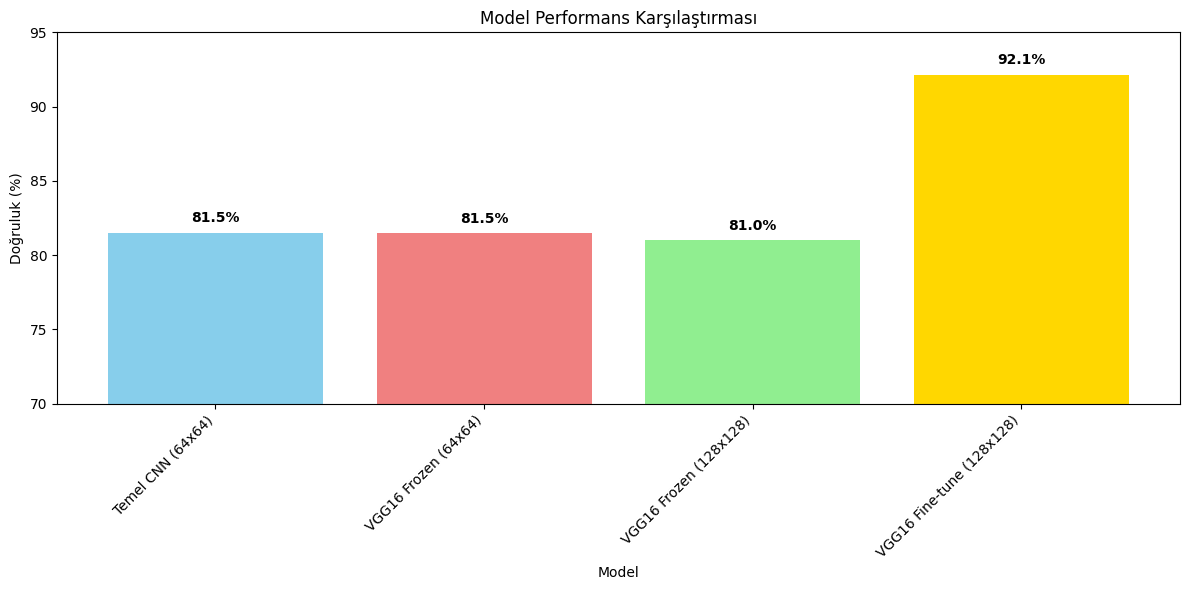


PERFORMANS İYİLEŞTİRMESİ:
Başlangıç (Temel CNN): 81.50%
Son Model (Fine-tune): 92.14%
Toplam İyileşme: +10.63 puan


In [20]:
# =========================
# 9. SONUÇ KARŞILAŞTIRMA
# =========================

# Tüm modellerin performansını karşılaştır
results = {
    "Temel CNN (64x64)": baseline_acc,
    "VGG16 Frozen (64x64)": vgg16_64_acc,
    "VGG16 Frozen (128x128)": vgg16_128_acc,
    "VGG16 Fine-tune (128x128)": finetune_acc
}

results_df = pd.DataFrame.from_dict(results, orient="index", columns=["Doğrulama Doğruluğu"])
results_df["Doğruluk (%)"] = (results_df["Doğrulama Doğruluğu"] * 100).round(2)

print("MODEL PERFORMANS KARŞILAŞTIRMASI")
print("=" * 50)
print(results_df)

# Görselleştirme
plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(results)), [v*100 for v in results.values()], 
               color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
plt.xlabel("Model")
plt.ylabel("Doğruluk (%)")
plt.title("Model Performans Karşılaştırması")
plt.xticks(range(len(results)), results.keys(), rotation=45, ha='right')
plt.ylim(70, 95)

# Bar üzerine değerleri yaz
for i, (bar, acc) in enumerate(zip(bars, results.values())):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{acc*100:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# İyileşme yüzdelerini hesapla
baseline_perf = baseline_acc * 100
final_perf = finetune_acc * 100
improvement = final_perf - baseline_perf

print(f"\nPERFORMANS İYİLEŞTİRMESİ:")
print(f"Başlangıç (Temel CNN): {baseline_perf:.2f}%")
print(f"Son Model (Fine-tune): {final_perf:.2f}%")
print(f"Toplam İyileşme: +{improvement:.2f} puan")

## 10. Grad-CAM Açıklanabilirlik
#### a. Modelin ezberleyip ezberlmediği Grad-CAM yöntemiyle gözlemlendi.

GRAD-CAM AÇIKLANABILIRLIK ANALİZİ

 Sunak sınıfı için Grad-CAM:


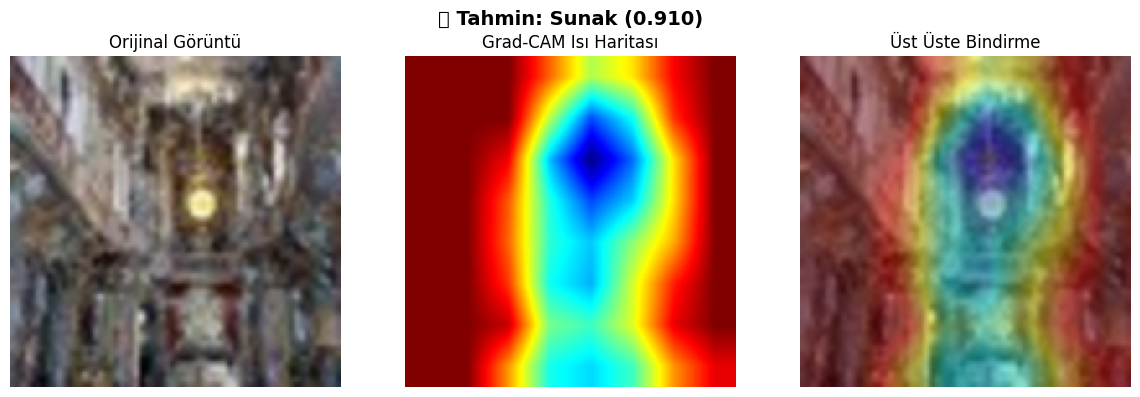


 Kubbe (Dış) sınıfı için Grad-CAM:


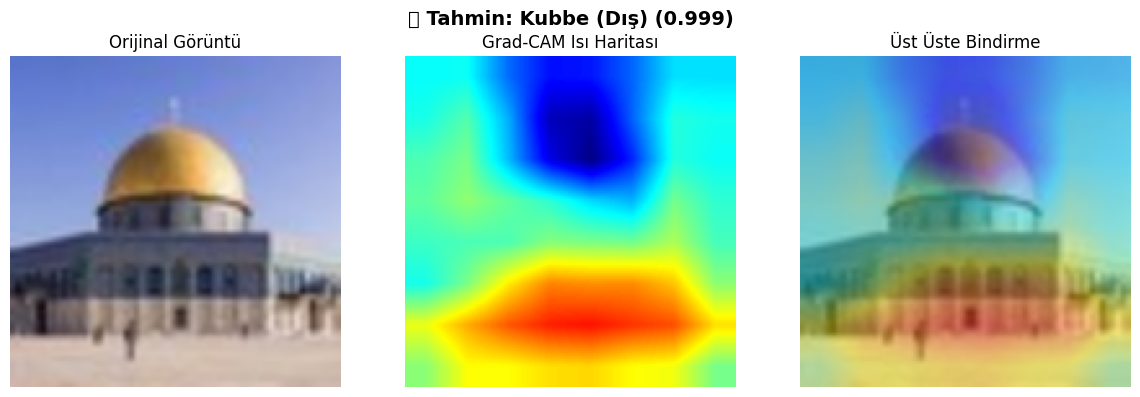


 Uçan Payanda sınıfı için Grad-CAM:


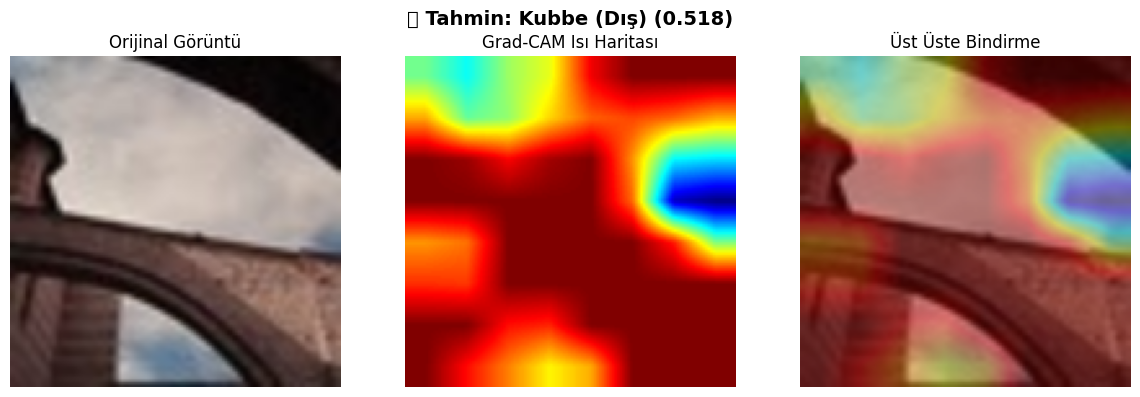


 Vitray sınıfı için Grad-CAM:


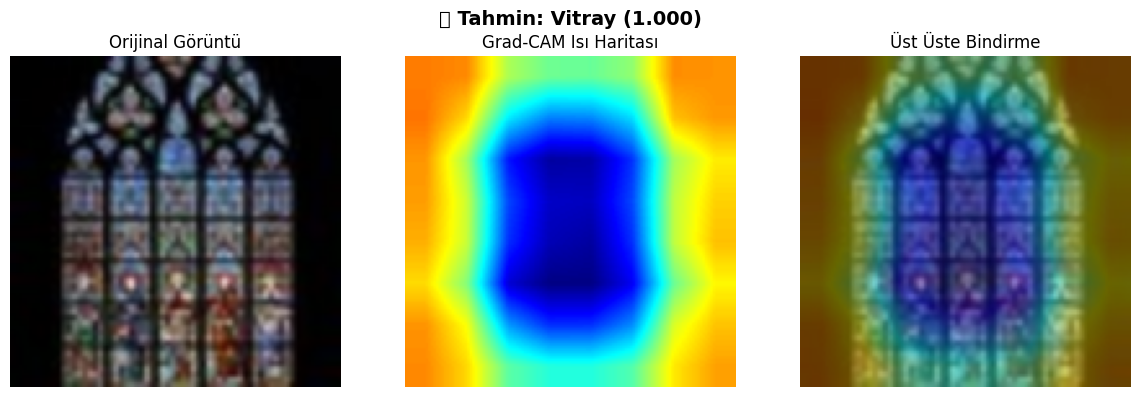

In [28]:
# =========================
# 10. GRAD-CAM AÇIKLANABILIRLIK
# =========================


def get_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """Grad-CAM ısı haritası oluştur"""
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

def display_gradcam(img_path, model, class_names_tr, last_conv_layer_name="block5_conv3"):
    """Grad-CAM görselleştirmesi"""
    # Görüntüyü yükle ve hazırla
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(128,128))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    
    # Tahmin yap
    preds = model.predict(img_array, verbose=0)
    pred_class = np.argmax(preds[0])
    pred_prob = preds[0][pred_class]
    
    # Grad-CAM hesapla
    heatmap = get_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=pred_class)
    
    # Görüntüleri hazırla
    img_cv = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    img_cv = cv2.resize(img_cv, (128,128))
    heatmap = cv2.resize(heatmap, (img_cv.shape[1], img_cv.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img_cv, 0.6, heatmap, 0.4, 0)
    
    # Görselleştir
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(img_cv)
    plt.title("Orijinal Görüntü")
    plt.axis("off")
    
    plt.subplot(1,3,2)
    plt.imshow(heatmap)
    plt.title("Grad-CAM Isı Haritası")
    plt.axis("off")
    
    plt.subplot(1,3,3)
    plt.imshow(superimposed_img)
    plt.title("Üst Üste Bindirme")
    plt.axis("off")
    
    plt.suptitle(f"🔍 Tahmin: {class_names_tr[pred_class]} ({pred_prob:.3f})", 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Her sınıftan bir örnek için Grad-CAM
print("GRAD-CAM AÇIKLANABILIRLIK ANALİZİ")
print("=" * 50)

sample_classes = ["altar", "dome(outer)", "flying_buttress", "stained_glass"]
for class_name in sample_classes:
    class_dir = os.path.join(TEST_DIR, class_name)
    if os.path.exists(class_dir):
        sample_img = os.path.join(class_dir, random.choice(os.listdir(class_dir)))
        print(f"\n {label_map[class_name]} sınıfı için Grad-CAM:")
        display_gradcam(sample_img, vgg16_finetune, class_names_tr)

# Genel Değerlendirme

## Proje Amacı
Bu projede, **CNN tabanlı modeller kullanılarak mimari miras öğelerinin (sunak, apsis, kubbe, uçan payanda, vitray vb.) sınıflandırılması** hedeflendi.  
Amaç, farklı mimari unsurların bilgisayarla görü teknikleriyle ayrıştırılabilmesi ve kültürel mirasın dijital olarak analizi için bir temel oluşturmaktır.

---

## Uygulanan Modeller ve Sonuçlar

| Model                        | Girdi Boyutu | Strateji             | En İyi Val Doğruluk | Test Doğruluk |
|------------------------------|--------------|----------------------|---------------------|---------------|
| **Temel CNN**                | 64x64        | Sıfırdan eğitim      | **81.5%**           | 70.7%         |
| **VGG16 (Frozen)**           | 64x64        | Transfer (dondurulmuş) | 81.4%           | -             |
| **VGG16 (Frozen)**           | 128x128      | Transfer (dondurulmuş) | 81.0%           | -             |
| **VGG16 (Fine-Tuning)**     | 128x128      | Son katmanlar açıldı | **92.1%**           | **91.7%**     |

---

## Bulgular
- **Fine-tuning**, transfer learning’in gerçek gücünü ortaya çıkardı: doğruluk +10 puan arttı.
- **Kolay sınıflar**: Vitray, Kubbe(Dış), Tonoz → net görsel ayrıştırıcılara sahip; %95+ başarı.
- **Zor sınıflar**: Apsis ve Uçan Payanda → veri azlığı + görsel benzerlik nedeniyle hata eğiliminde.
- **Veri dengesizliği etkisi**: Küçük sınıflarda F1 düşüyor (ör. apsis %74).
- Eğitim süresi artmasına rağmen Fine-tuning hem doğruluk hem genelleme açısından en iyi seçim.

---

## Grad-CAM Açıklanabilirlik

- **Doğru tahminlerde** (ör. vitray, kubbe dış):  
  Model, _insanın da ayırt edeceği bölgeler_ (cam yüzeyi, kubbe silueti) üzerine odaklanıyor.
  
- **Yanlış tahminlerde** (ör. uçan payanda ↔ kubbe dış):  
  Benzer mimari çizgiler / geometriler üzerinde yoğunlaşarak karışıklık yaşadığı açıklanabiliyor.

Bu sayede, modelin **ezberlemediği**, gerçekten anlamlı bölgelerden beslendiği görülüyor.  

---

## Sonuç
- En iyi model: **VGG16 Fine-Tuning (128x128)**  
- **Test Seti Başarımı**: %91.7 doğruluk  
- **Grad-CAM** ile açıklanabilirlik sağlandı, güvenilirlik arttı.  
- Proje, **hem yüksek doğruluk** hem de **yorumlanabilirlik** açısından başarılı bir sonuca ulaşmıştır.